In [1]:
import sys
from pathlib import Path
sys.path.append(str(Path("./multiscale-ssh")))  # replace with real path

from DL_models import UNet  
from DL_models import CNN
from FCNN import FCNN
from loss_function import CombinedLoss
from train_test import train_model, train_model_r2
from train_test import evaluate_model_sr
from visualization import plot_predictions_vs_targets, plot_predictions_vs_targets_sr
from visualization import plot_mean_power_spectrum, plot_mean_power_spectrum_sr
from visualization import plot_train_val_losses
from visualization import plot_mean_esr
from dataloading import prepare_dataloaders, prepare_dataloaders_multiVar
from qualitative_eval import mse, r2_score, pearson_corr, first_esr_exceeds_half

In [2]:
from xgcm import Grid
import pop_tools
import gcsfs
import fsspec as fs
import numpy as np
import xesmf as xe
import xarray as xr
import random
import matplotlib.pyplot as plt
import warnings
from xgcm import Grid
import importlib
# import preprocessing
import os
import xrft
import gcm_filters
import random
import scipy
from scipy.ndimage import convolve

warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader, Dataset

/srv/conda/envs/notebook/lib/python3.12/site-packages/pop_tools/__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


# Helper Functions

In [3]:
def r2_per_sample(y_true, y_pred):
    n_samples = y_true.shape[0]
    r2_scores = np.empty(n_samples)
    
    for i in range(n_samples):
        yt = y_true[i].reshape(-1)
        yp = y_pred[i].reshape(-1)
        ss_res = np.sum((yt - yp) ** 2)
        ss_tot = np.sum((yt - np.mean(yt)) ** 2)
        r2_scores[i] = 1 - ss_res / ss_tot
    
    return r2_scores

# Data Preprocessing

In [4]:
#ds_HR_reg = xr.open_dataset("gs://leap-persistent/panalluri/ds_HR_globalRegions.zarr", engine="zarr", chunks={}) 
#ds_LR_reg = xr.open_dataset("gs://leap-persistent/panalluri/ds_LR_globalRegions.zarr", engine="zarr", chunks={}) 
#ds_HF_reg = xr.open_dataset("gs://leap-persistent/panalluri/ds_HF_globalRegions.zarr", engine="zarr", chunks={}) 

In [9]:
ds_HR = xr.open_dataset("gs://leap-persistent/panalluri/ds_HR.zarr", engine="zarr", chunks={}) 
ds_LR = xr.open_dataset("gs://leap-persistent/panalluri/ds_LR.zarr", engine="zarr", chunks={}) 
ds_HF = xr.open_dataset("gs://leap-persistent/panalluri/ds_HF.zarr", engine="zarr", chunks={}) 

# Select region of interest
ds_HR_reg = ds_HR.isel(xt_ocean=slice(1100,1300), yt_ocean=slice(1500,1800))
ds_LR_reg = ds_LR.isel(xt_ocean=slice(1100,1300), yt_ocean=slice(1500,1800))
ds_HF_reg = ds_HF.isel(xt_ocean=slice(1100,1300), yt_ocean=slice(1500,1800))

In [5]:
# Config choices Abigail chose

input_channels = 6
output_channels = 1
conv_layers = 7
kernel = 5
#init_bound = 0.5
kernel_hidden = 3
activation = "ReLU"
arch = "fcnn"

config={"input_channels":input_channels,
        "output_channels":output_channels,
        "activation":activation,
        "arch":arch,
        "conv_layers":conv_layers,
        "kernel":kernel,
        "kernel_hidden":kernel_hidden}

In [6]:
model = FCNN(config=config)
model

FCNN(
  (conv): Sequential(
    (0): Conv2d(6, 128, kernel_size=(5, 5), stride=(1, 1), padding=same, padding_mode=reflect)
    (1): ReLU()
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=reflect)
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=reflect)
    (7): ReLU()
    (8): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=reflect)
    (10): ReLU()
    (11): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=reflect)
    (13): ReLU()
    (14): BatchNorm2d(32, eps=1e-05, momentum=0.1, affi

# Case 1: R2 Early Stopping, MSELoss, Standardization, Patience = 30

In [11]:
var_LR = ['u_relative', 'v_relative', 't_ref', 'surface_temp', 'q_ref', 'slp']
train_loader, val_loader, test_loader, HF_test, LR_test = prepare_dataloaders_multiVar(ds_HF_reg, ds_LR_reg, var_LR=var_LR, var_HF='heatflux_diff', batch_size=32, normalization_type='standardization')

Training set size: 510
Validation set size: 109
Testing set size: 111


In [12]:
criterion = nn.MSELoss() # default is alpha=1
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
device = torch.device("cuda")

train_losses, val_losses, r2_vals = train_model_r2(model, train_loader, val_loader,
            criterion, optimizer, device,
            save_path='./model_r2earlyStop_regional.pth',
            n_epochs=2000, patience=30) # n_epochs=2000)

Trainable Parameters: 149569
Epoch 1, Train Loss: 5.116e-01, Val Loss: 5.069e-01, Val R²: 0.4468, Epoch Time: 12.12s
Model saved at epoch 1
Epoch 2, Train Loss: 4.535e-01, Val Loss: 4.616e-01, Val R²: 0.4933, Epoch Time: 12.11s
Model saved at epoch 2
Epoch 3, Train Loss: 4.314e-01, Val Loss: 4.687e-01, Val R²: 0.4826, Epoch Time: 12.08s
Model saved at epoch 3
Epoch 4, Train Loss: 4.219e-01, Val Loss: 4.559e-01, Val R²: 0.4943, Epoch Time: 12.10s
Model saved at epoch 4
Epoch 5, Train Loss: 4.168e-01, Val Loss: 4.523e-01, Val R²: 0.4955, Epoch Time: 12.15s
Model saved at epoch 5
Epoch 6, Train Loss: 4.132e-01, Val Loss: 4.377e-01, Val R²: 0.5002, Epoch Time: 12.19s
Model saved at epoch 6
Epoch 7, Train Loss: 3.906e-01, Val Loss: 4.798e-01, Val R²: 0.4871, Epoch Time: 12.26s
Model saved at epoch 7
Epoch 8, Train Loss: 3.882e-01, Val Loss: 4.730e-01, Val R²: 0.4908, Epoch Time: 12.31s
Model saved at epoch 8
Epoch 9, Train Loss: 3.923e-01, Val Loss: 4.305e-01, Val R²: 0.5209, Epoch Time: 12

In [13]:
device = torch.device("cuda")
sgs_pred = evaluate_model_sr(model, device, test_loader, HF_test, './model_r2earlyStop_regional.pth')
sgs_pred

Loaded model parameters from ./model_r2earlyStop_regional.pth


array([[[-1.3378664 , -1.3717953 , -1.3411382 , ..., -0.39097413,
         -0.2558716 , -0.3093404 ],
        [-1.4085822 , -1.4367503 , -1.4239035 , ..., -1.0287013 ,
         -0.9071981 , -1.0269415 ],
        [-1.7121123 , -1.7051376 , -1.6598861 , ..., -1.181617  ,
         -1.0141326 , -1.0746752 ],
        ...,
        [ 0.5329686 ,  0.5421958 ,  0.5113542 , ...,  0.00460657,
         -0.15101184, -0.05630639],
        [ 0.53392226,  0.5436496 ,  0.51300377, ...,  0.06758635,
         -0.10763901, -0.03461774],
        [ 0.53680915,  0.54672635,  0.5160748 , ...,  0.15293367,
         -0.02901763,  0.04246026]],

       [[ 0.47819942,  0.42628074,  0.42249137, ...,  0.14443637,
          0.13367723,  0.1101912 ],
        [ 0.49889767,  0.4458693 ,  0.4416396 , ...,  0.18706518,
          0.17117332,  0.14085437],
        [ 0.5176478 ,  0.46297207,  0.45826098, ...,  0.19297765,
          0.19540909,  0.15858404],
        ...,
        [ 0.556519  ,  0.5472204 ,  0.5496144 , ...,  

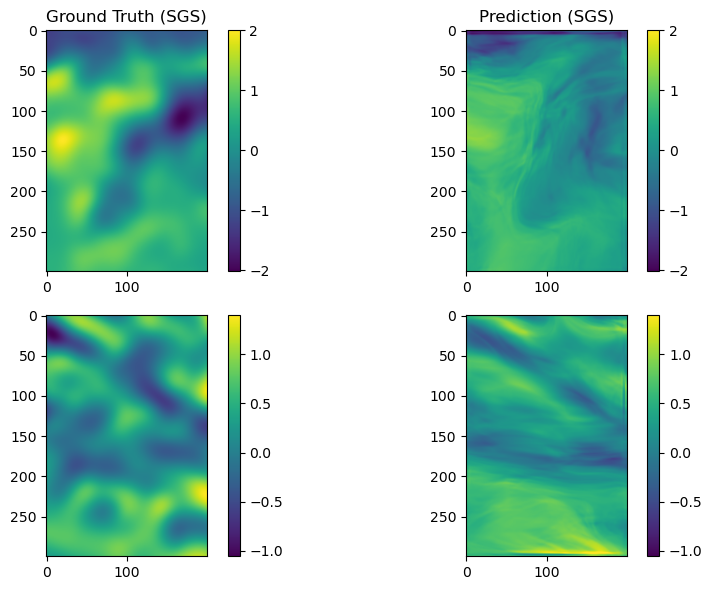

In [14]:
plot_predictions_vs_targets(HF_test, sgs_pred, num_samples=2, cmap='viridis', cbar_shared_lims=True)

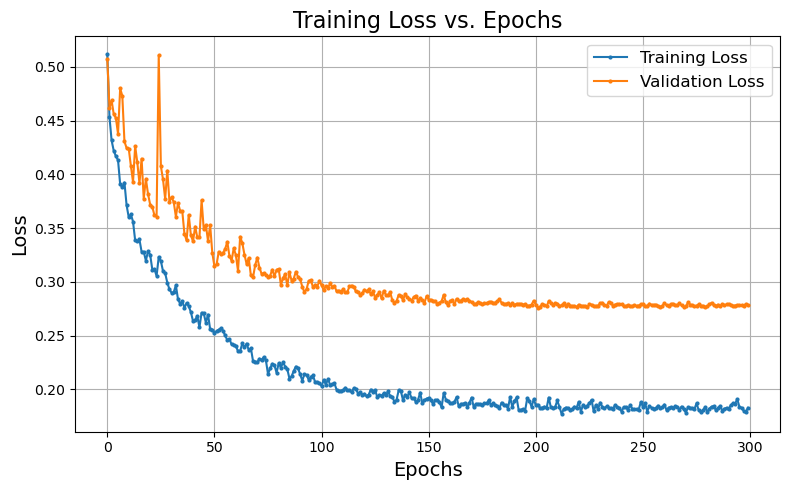

In [15]:
plot_train_val_losses(train_losses, val_losses)

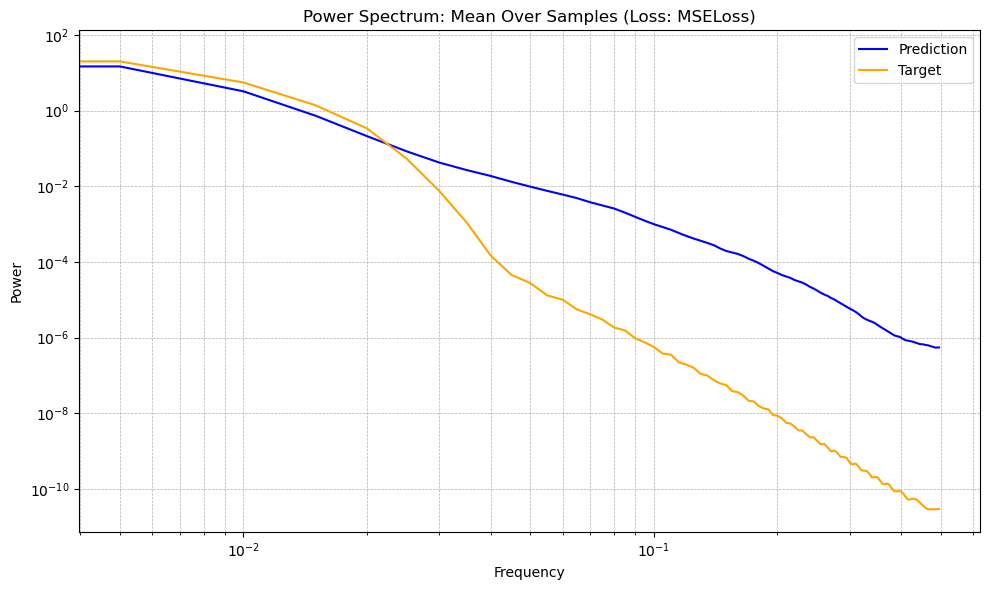

In [16]:
plot_mean_power_spectrum(sgs_pred, HF_test, loss_name="MSELoss", alpha_label="", figsize=(10, 6), show_slopes=False)

In [17]:
mse_val = mse(HF_test, sgs_pred)
r = pearson_corr(HF_test, sgs_pred)
r2 = r2_score(HF_test, sgs_pred)
k_thresh = first_esr_exceeds_half(sgs_pred, HF_test)
print(f"MSE is {mse_val}")
print(f"Pearson correlation coefficient is {r}")
print(f"r2 is {r2}")
print(f"ESR first exceeds half at {k_thresh}")

All frequencies have ESR > 1.0
MSE is 0.23659487068653107
Pearson correlation coefficient is 0.8794974184796412
r2 is 0.7732707262039185
ESR first exceeds half at None


In [18]:
r2_scores_mse = r2_per_sample(HF_test, sgs_pred)
r2_scores_mse

array([0.65394467, 0.47728741, 0.75817651, 0.38470912, 0.71061957,
       0.63949716, 0.80110967, 0.75981188, 0.81940711, 0.84106994,
       0.72266841, 0.51302612, 0.65358895, 0.60753047, 0.63592446,
       0.67902493, 0.61158228, 0.79380792, 0.60040015, 0.74094629,
       0.76053327, 0.69004399, 0.70033002, 0.39356345, 0.8418532 ,
       0.92423397, 0.73964059, 0.66662288, 0.6274848 , 0.60779631,
       0.81070346, 0.61971581, 0.6758424 , 0.74546647, 0.70724159,
       0.89358276, 0.54355514, 0.59109151, 0.80062735, 0.71337867,
       0.58662152, 0.70791823, 0.6554656 , 0.65859938, 0.30145097,
       0.56677675, 0.74616987, 0.50991964, 0.88252342, 0.59452289,
       0.61089766, 0.84548885, 0.65173173, 0.66132653, 0.60726237,
       0.65796942, 0.68498564, 0.43556601, 0.65463424, 0.55871403,
       0.68499267, 0.61005247, 0.64963764, 0.41112614, 0.61725897,
       0.75053793, 0.55333138, 0.77363193, 0.77404654, 0.75297284,
       0.66297227, 0.62679243, 0.71766746, 0.83364594, 0.79598

# Case 2: Val Loss Early Stopping, MSELoss, Standardization, Patience = 30

In [19]:
criterion = nn.MSELoss() # default is alpha=1
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
device = torch.device("cuda")

train_losses, val_losses = train_model(model, train_loader, val_loader,
            criterion, optimizer, device,
            save_path='./model_valLosearlyStop_regional.pth',
            n_epochs=2000, patience=30) # n_epochs=2000)

Trainable Parameters: 149569
Epoch 1, Train Loss: 2.870e-01, Val Loss: 3.276e-01, Epoch Time: 12.65s
Model saved at epoch 1
Epoch 2, Train Loss: 2.479e-01, Val Loss: 3.475e-01, Epoch Time: 12.62s
Model saved at epoch 2
Epoch 3, Train Loss: 2.301e-01, Val Loss: 3.000e-01, Epoch Time: 12.69s
Model saved at epoch 3
Epoch 4, Train Loss: 2.238e-01, Val Loss: 2.903e-01, Epoch Time: 12.67s
Model saved at epoch 4
Epoch 5, Train Loss: 2.277e-01, Val Loss: 3.016e-01, Epoch Time: 12.73s
Model saved at epoch 5
Epoch 6, Train Loss: 2.195e-01, Val Loss: 2.988e-01, Epoch Time: 12.71s
Model saved at epoch 6
Epoch 7, Train Loss: 2.257e-01, Val Loss: 3.016e-01, Epoch Time: 12.72s
Model saved at epoch 7
Epoch 8, Train Loss: 2.123e-01, Val Loss: 2.935e-01, Epoch Time: 12.73s
Model saved at epoch 8
Epoch 9, Train Loss: 2.118e-01, Val Loss: 2.859e-01, Epoch Time: 12.71s
Model saved at epoch 9
Epoch 10, Train Loss: 2.102e-01, Val Loss: 2.805e-01, Epoch Time: 12.68s
Model saved at epoch 10
Epoch 11, Train Los

In [20]:
device = torch.device("cuda")
sgs_pred = evaluate_model_sr(model, device, test_loader, HF_test, './model_valLosearlyStop_regional.pth')
sgs_pred

Loaded model parameters from ./model_valLosearlyStop_regional.pth


array([[[-1.6146333 , -1.7368151 , -1.6712289 , ..., -0.56063986,
         -0.4760377 , -0.56163377],
        [-1.314593  , -1.4212663 , -1.3775347 , ..., -0.3807917 ,
         -0.30182773, -0.32920116],
        [-1.5253936 , -1.6356397 , -1.5853568 , ..., -0.19958124,
         -0.14530931, -0.20880774],
        ...,
        [ 0.69916487,  0.642691  ,  0.6583843 , ...,  0.17833275,
          0.10713994,  0.30629122],
        [ 0.6510213 ,  0.5936103 ,  0.6079227 , ...,  0.21254581,
          0.1388948 ,  0.3570451 ],
        [ 0.6475941 ,  0.5892264 ,  0.60540944, ...,  0.20173225,
          0.15500832,  0.36219662]],

       [[ 0.26222995,  0.14862198,  0.22617862, ...,  0.62630576,
          0.60196847,  0.5667691 ],
        [ 0.08227734, -0.02078136,  0.04563235, ...,  1.3112081 ,
          1.3040926 ,  1.2778151 ],
        [ 0.09982511, -0.00348893,  0.06547593, ...,  0.700628  ,
          0.6834327 ,  0.66016704],
        ...,
        [ 0.27531928,  0.2732795 ,  0.2914249 , ...,  

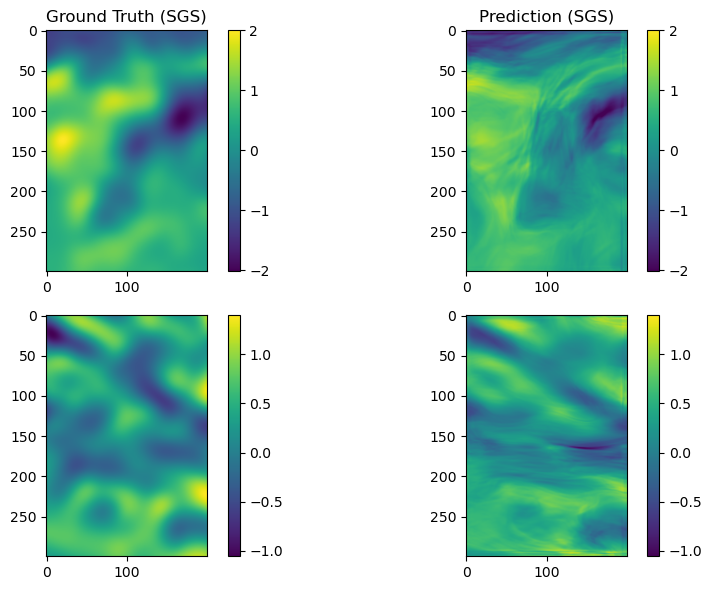

In [21]:
plot_predictions_vs_targets(HF_test, sgs_pred, num_samples=2, cmap='viridis', cbar_shared_lims=True)

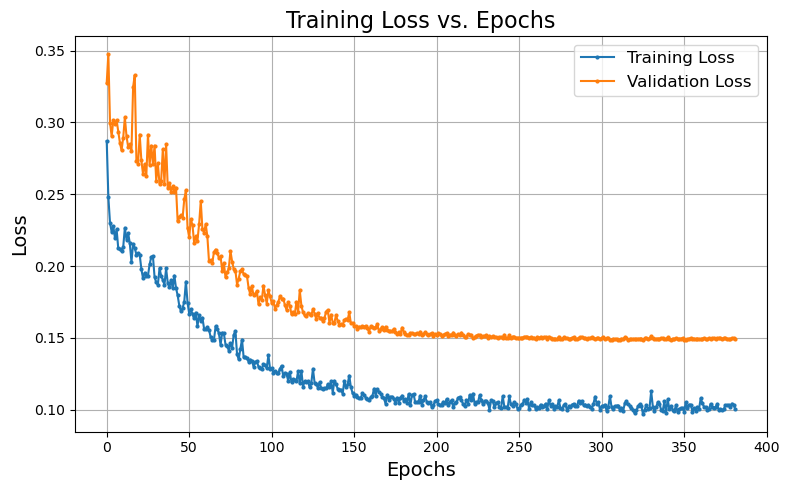

In [22]:
plot_train_val_losses(train_losses, val_losses)

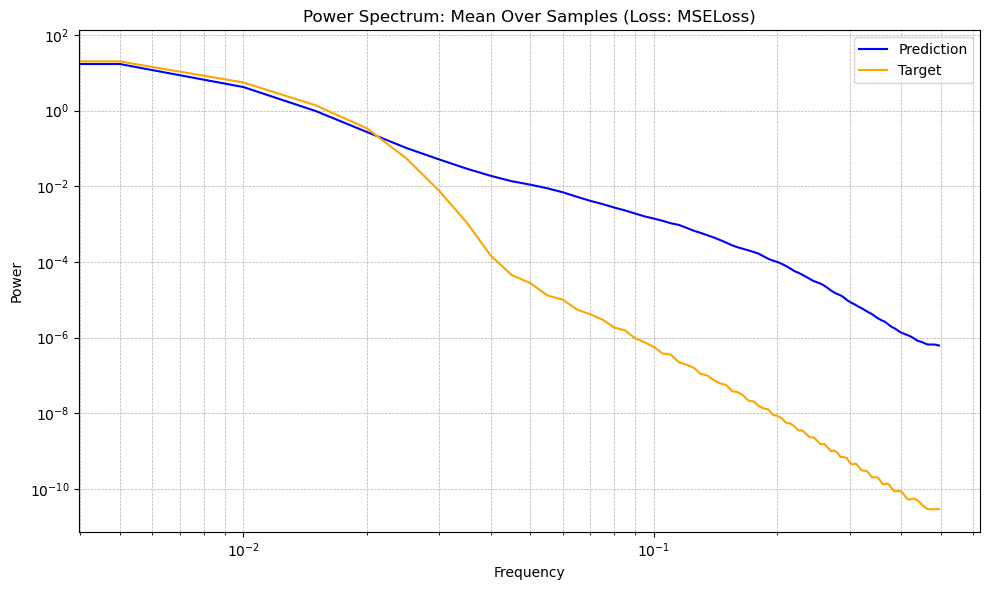

In [23]:
plot_mean_power_spectrum(sgs_pred, HF_test, loss_name="MSELoss", alpha_label="", figsize=(10, 6), show_slopes=False)

In [24]:
mse_val = mse(HF_test, sgs_pred)
r = pearson_corr(HF_test, sgs_pred)
r2 = r2_score(HF_test, sgs_pred)
k_thresh = first_esr_exceeds_half(sgs_pred, HF_test)
print(f"MSE is {mse_val}")
print(f"Pearson correlation coefficient is {r}")
print(f"r2 is {r2}")
print(f"ESR first exceeds half at {k_thresh}")

All frequencies have ESR > 1.0
MSE is 0.1365758329629898
Pearson correlation coefficient is 0.9322819747916721
r2 is 0.8691191673278809
ESR first exceeds half at None


In [25]:
r2_scores_mse_val = r2_per_sample(HF_test, sgs_pred)
r2_scores_mse_val

array([0.8238582 , 0.70960647, 0.85052162, 0.44709766, 0.85371804,
       0.77992845, 0.87843025, 0.86795628, 0.91060066, 0.8912881 ,
       0.79058546, 0.69903207, 0.80482167, 0.82563126, 0.86470073,
       0.82647461, 0.86537486, 0.90647125, 0.83790767, 0.84672791,
       0.8450411 , 0.86545104, 0.89647788, 0.61637163, 0.90401709,
       0.96418941, 0.85267544, 0.82453406, 0.81985414, 0.82490051,
       0.85581142, 0.79982662, 0.82850981, 0.84325075, 0.78622127,
       0.94324195, 0.74836683, 0.78809547, 0.85759217, 0.86907184,
       0.73407298, 0.86854386, 0.80854338, 0.79850638, 0.57982862,
       0.8451823 , 0.88293689, 0.81804973, 0.89811462, 0.68794626,
       0.78360498, 0.93606991, 0.78344762, 0.81179678, 0.78609395,
       0.83265537, 0.84408557, 0.58306825, 0.82350504, 0.77723449,
       0.83874846, 0.74881452, 0.70769143, 0.71201289, 0.75975215,
       0.86968791, 0.79208219, 0.85759056, 0.84194529, 0.85064757,
       0.82399029, 0.7733981 , 0.7537297 , 0.92490363, 0.87680

# Comparison

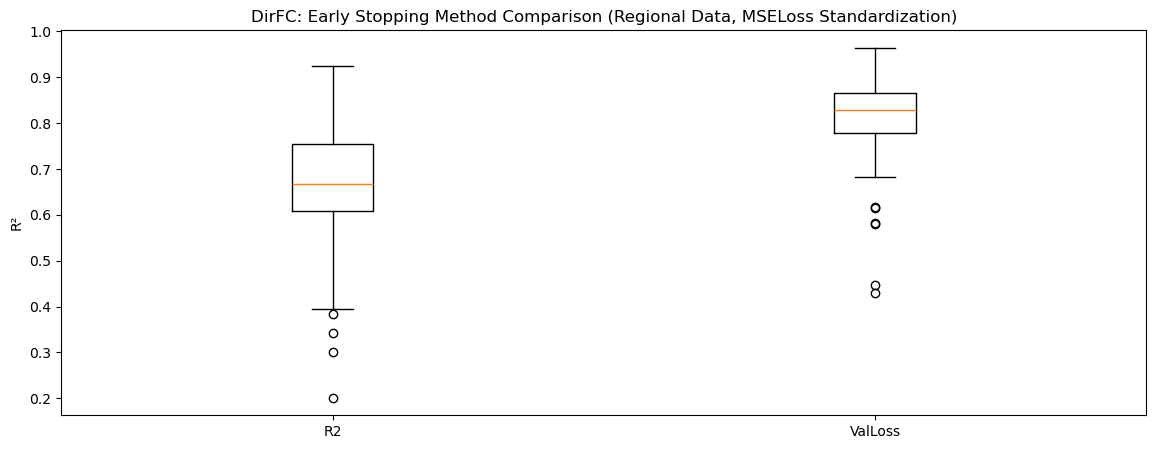

In [26]:
data = [r2_scores_mse, r2_scores_mse_val]

plt.figure(figsize=(14, 5))
plt.boxplot(data, vert=True)  # each array becomes a separate boxplot
plt.xticks([1, 2], ["R2", "ValLoss"])  # label each box
plt.ylabel("R²")
plt.title("DirFC: Early Stopping Method Comparison (Regional Data, MSELoss Standardization)")
plt.show()